# Принятие решений в бизнесе на основе данных. Приотизация гипотез, А/В тестирование для интернет-магазина.

Исследование данных крупного интеренет-магазина. 

Цель - увеличение выручки. 
Совместно с отделом маркетинга подготовлены гипотезы, приоритизируем их, запустим A/B-тест и проанализируем результаты.

Описание данных:


**Файл `/datasets/hypothesis.csv`** - содержит 9 гипотез по увеличению выручки интернет-магазина 
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Файл `/datasets/orders.csv`** - данные для A/B-теста
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.


**Файл `/datasets/visitors.csv`**
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


Для анализа нам необходимо:
- изучить данные, проверить датафреймы на наличие пропусков и аномалий
- провести А/А-тестирование
- приотизировать гипотезы
- оценить А/В-тестирование: изучить измнение кумулятивной выручки, кумулятивного среднего чека, кумулятивного среднего количества заказов по группам
- оценить статистическую значимость различий 
- сформулировать выводы


## Откроем файлы с данными и изучим общую информацию

Импортируем необходимые библиотеки, считываем данные из csv-файла в датафрейм и сохраняем в переменную hypothesis.

In [44]:
import pandas as pd
import seaborn as sns
import pylab as pl
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import math as mth
from matplotlib.ticker import FuncFormatter
from scipy import stats as sts

In [45]:
try:
    hipothesis = pd.read_csv('datasets/hypothesis.csv')
except:
    hipothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

Выведем 9 строчек датафрейма data на экран

In [46]:
hipothesis.head(9)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [47]:
# приведем названия столбцов к нижнему регистру
hipothesis.columns = hipothesis.columns.str.lower()
# проверим, как изменились названия
hipothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Выведем основную информацию о датафрейме:

In [48]:
hipothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [49]:
hipothesis.duplicated().sum()

0

In [50]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except: 
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [51]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [52]:
# переименуем столбцы
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})
# проверим, как изменились названия
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [53]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [54]:
orders.duplicated().sum()

0

In [55]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except: 
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [56]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [57]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [58]:
# поменяем типы данных столбцов 
orders['date'] = orders['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].astype('datetime64[D]')

In [59]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [60]:
visitors.duplicated().sum()

0

На текущем этапе мы ознакомились с даными трех датафреймов, изменили названия столбцов, убедились в отсутствии явных дубликатов, преобразовали типы данных столбцов date таблиц visitors и orders.

###  Проведем базовую проверку данных

- Для начала определим количество групп А/В-теста 
- Период, за который нам доступны данные 
- Проверим корректность распределения на группы 

In [61]:
#Определим количество групп А/В-теста:

visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [62]:
# Определим дату начала и окончания теста
print('\nДата начала теста {}\nДата окончания теста {}\n'.format(orders['date'].min(),\
                                                                 orders['date'].max()))



Дата начала теста 2019-08-01 00:00:00
Дата окончания теста 2019-08-31 00:00:00



Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


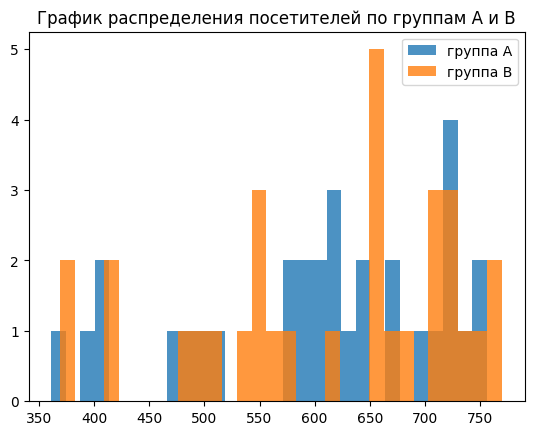

In [63]:
# определим количество посетителей в каждой группе
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors']\
                                                 .sum(), visitors[visitors['group']=='B']\
                                                 ['visitors'].sum()))
# количество покупок в группах
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))
# построим график распределения посетителей по группам
plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8,\
         label='группа A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, \
         label='группа B', bins = 30)
plt.legend()
plt.title('График распределения посетителей по группам A и B')
plt.show()

In [64]:
# проверим, встречаются ли пользователти, попавшие в обе группы
ab_group = orders.pivot_table(index='visitor_id',\
                              values='group', aggfunc='nunique').reset_index()
print(ab_group)
ab_group_count = ab_group.query('group == 2')['visitor_id'].count()
print('Количество пользователей, находящихся одновременно в 2 группах:', ab_group_count)

      visitor_id  group
0        5114589      1
1        6958315      1
2        8300375      2
3       11685486      1
4       39475350      1
...          ...    ...
1026  4266935830      2
1027  4278982564      1
1028  4279090005      1
1029  4281247801      1
1030  4283872382      1

[1031 rows x 2 columns]
Количество пользователей, находящихся одновременно в 2 группах: 58


In [65]:
print('Доля пользователей, попавших в обе группы составляет {} %'.format\
      (round(100*ab_group_count/(orders['visitor_id'].count()))))

Доля пользователей, попавших в обе группы составляет 5 %


Перед нами данные за август 2019 года, пользователи распределены на 2 группы - А и В. Кроме того, некоторые пользователи попали одновременно в обе группы, доля таких пользователей составляет около 5%. Принимаем решение оставить в датасете пользователей, попоавших в обе группы, так как их удаление может уменьшить выборку и повлиять на дальнейший анализ.

## Приоритизация гипотез.

### Фреймворк ICE
Один из самых популярных способов приоритизации задач — **ICE** 

(от англ. `impact, confidence, effort / ease` «влияние, уверенность, усилия / простота»):

In [66]:
pd.options.display.max_colwidth = 210
hipothesis_priority = pd.DataFrame()
hipothesis_priority['hypothesis'] = hipothesis['hypothesis']
hipothesis_priority['ICE'] = round(((hipothesis['impact'] *\
                              hipothesis['confidence'] )/ hipothesis['efforts']),2)
hipothesis_priority.sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Наиболее перспективные гипотезы по ICE: 8, 0, 7**


### Фреймворк RICE

Фреймворк **RICE** состоит из четырёх компонент:
- `Reach` — скольких пользователей затронет изменение, которое вы хотите внести;
- `Impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- `Confidence` — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- `Efforts` — сколько стоит протестировать эту гипотезу.


In [67]:
hipothesis_priority['RICE'] = (hipothesis['reach']* hipothesis['impact']* \
                      hipothesis['confidence'])/hipothesis['efforts']
hipothesis_priority.sort_values(by='RICE', ascending=False)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


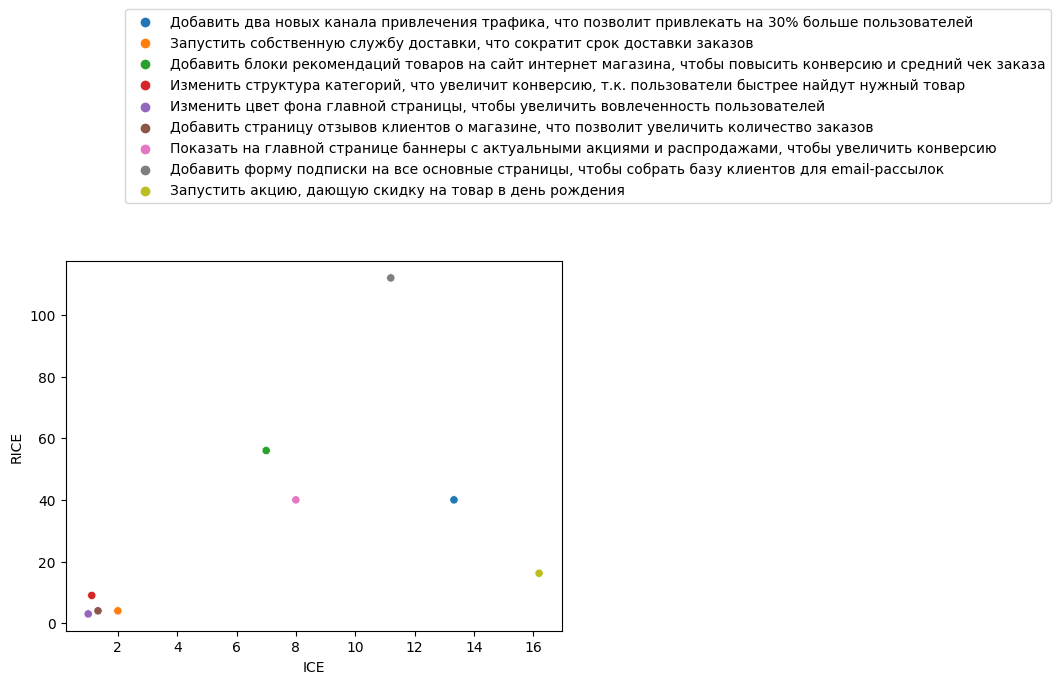

In [68]:
sns.scatterplot(data=hipothesis_priority, x='ICE', y="RICE", hue='hypothesis', sizes=(20, 200), legend='auto')
plt.legend(loc = 1, bbox_to_anchor = (2,1.7));

**Наиболее перспективными оказались гипотезы 7, 2, 0**, гипотеза 8, лидирующая по ICE имеет пятый приоритет по RICE. Первая позиция гипотезы 7 связана со значением параметра Reach равеного 10, в то время, как у других гипотез он меньше.

Как можно заметить, при применении RICE вместо ICE, приоритизация гипотез меняется. Поэтому кроме силы гипотез следует обращать внимание на то, скольких пользователей затронут изменения.

Для нас наиболее приоритетными являются гипотезы 7, 2, 0.

- (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- (2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


## Анализ A/B-теста

Результаты А/В-тестирования описаны в датафреймах orders и visitors.
### Оценим кумулятивную выручку по группам:

In [69]:
# создадим массив уникальных пар значений дат и групп тестирования
date_group = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])
# выведем кумулятивные показатели таблицы orders
orders_cmlt = date_group.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'],\
            x['group']==orders['group'])].agg({'date':'max', 'group':'max',\
            'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis = 1)
orders_cmlt.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
# выведем кумулятивные показатели таблицы visitors
visitors_cmlt = date_group.apply(lambda x: visitors[np.logical_and\
            (x['date'] >= visitors['date'], x['group']==visitors['group'])]\
            .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)
#объединим полученные данные в один датарейм
cumulative_data = orders_cmlt.merge(visitors_cmlt, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


*пояснения к таблице:*
- `orders` количество покупок
- `buyers` количество покупателей
- `revenue` выручка
- `visitors` количество посетителей

Построим график кумулятивной выручки по группам:

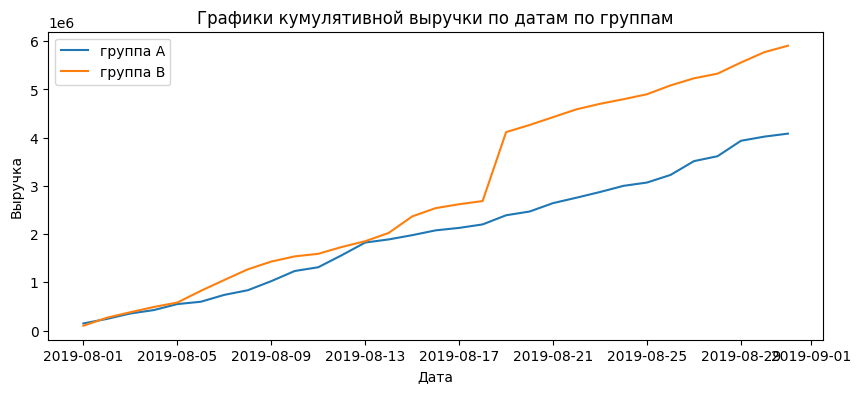

In [70]:
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_a['date'], cumulative_data_a['revenue'], label = 'группа A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['revenue'], label = 'группа B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по датам по группам')
plt.legend()
plt.show()

Исходя из графика, куммулятивная выручка `группы В` в течение всего анализируемого периода выше того же показателя `группы А`. При этом, наблюдаем увеличение выручки `группы В` с 20 августа почти в 2 раза, что может быть связано с увеличением количества заказов или с увеличеснием их стоимости (среднего чека). 

### Построим график кумулятивного среднего чека по группам. 

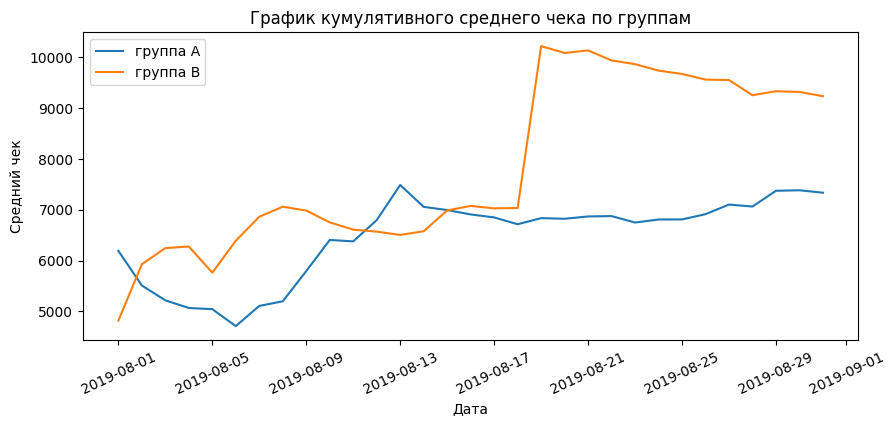

In [71]:
plt.figure(figsize=(10,4))
plt.plot(cumulative_data_a['date'], cumulative_data_a['revenue']/cumulative_data_a['orders'],\
         label = 'группа A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['revenue']/cumulative_data_b['orders'],\
         label = 'группа B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=25)
plt.legend()
plt.show()

В период с 17.08 по 21.08 кумулятивный средний чек `группы В` стремиотельно увеличивается, после чего до конца месяца относительно стабилен, уменьшается в пределах 10%. Показатель кумулятивного среднего чека `группы В` мог быть искажет более крупными заказами. Кумулятивный средний чек `группы А` в первую неделю месяца падает, затем возвращается к исходному уровню, увеличивается примерно до 7500 и остается стабильным до конца месяца. 
      
### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

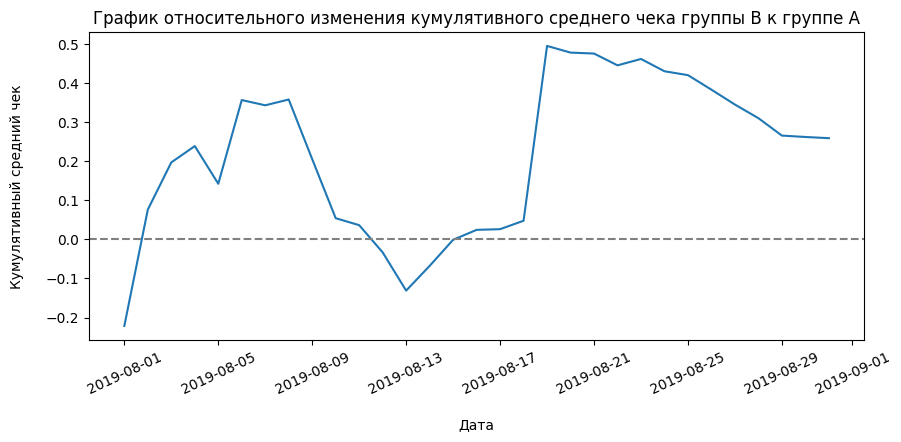

In [72]:
# собираем данные в одном датафрейме
merge_cmulative = cumulative_data_a.merge(cumulative_data_b, 
                                                   left_on='date', 
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])
# cтроим отношение средних чеков
plt.figure(figsize=(10,4))
plt.plot(merge_cmulative['date'], 
        (merge_cmulative['revenueB']/merge_cmulative['ordersB']) / 
        (merge_cmulative['revenueA']/merge_cmulative['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А')
plt.ylabel('Кумулятивный средний чек\n')
plt.xlabel('\nДата')
plt.xticks(rotation=25);

Все три графика демонстрируют похожую картину. Относительное изменение кумулятивного среднего чека `группы В` к `группе А` имеет так же резкие скачки, на что могли оказать влияние, как было отмечено выше, увеличение стоимости заказа. 

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

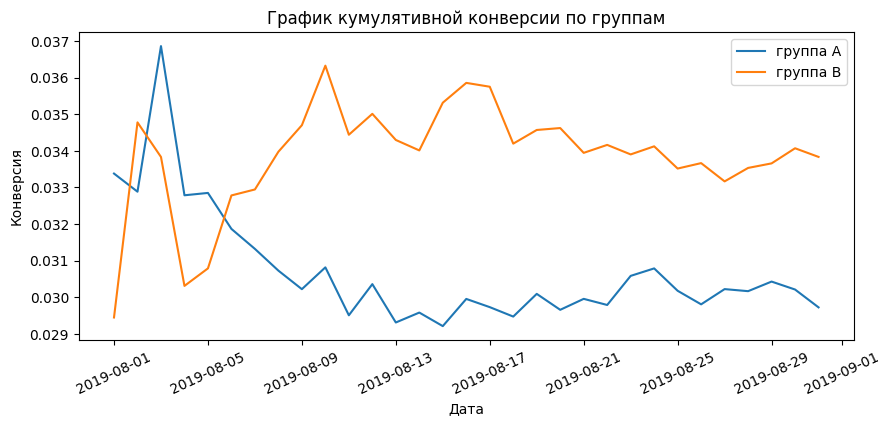

In [73]:
merge_cmulative['conversionA'] =  merge_cmulative['ordersA'] / merge_cmulative['visitorsA'] 
merge_cmulative['conversionB'] =  merge_cmulative['ordersB'] / merge_cmulative['visitorsB']
plt.figure(figsize=(10,4))
plt.plot(merge_cmulative['date'], merge_cmulative['conversionA'], label='группа A')
plt.plot(merge_cmulative['date'], merge_cmulative['conversionB'], label='группа B')
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.xticks(rotation=25)
plt.ylabel('Конверсия')
plt.legend()
plt.show()

В первую неделю августа `группа А` лидировала по уровню кумулятивной конверсии, в последующем, конверсия группы А падала с резкими перепадами. Кумулятивная конверсия `группы В` так же имеет резкие изменения, однако со второй недели месяца стабильно показывает большую конверсию, чем группа А. 

### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

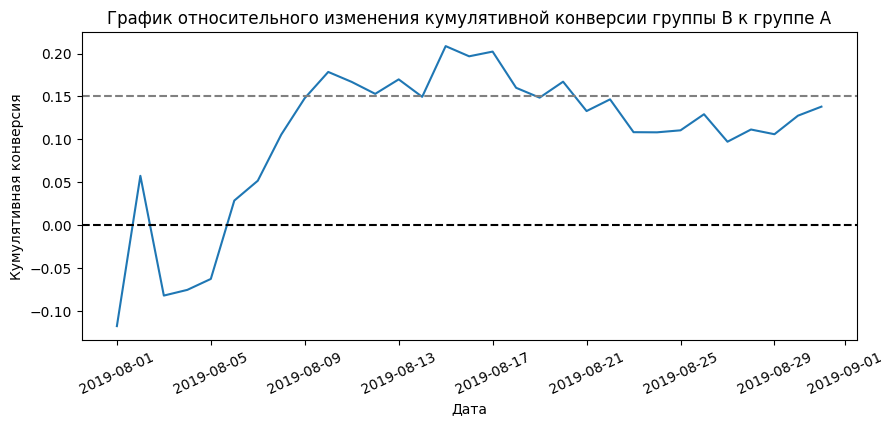

In [74]:
plt.figure(figsize=(10,4))
plt.plot(merge_cmulative['date'], ((merge_cmulative['conversionB']/merge_cmulative['conversionA'])-1))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=25)
plt.show()

Почти с самого начала теста `группа В` лидирует по конверсии и имеет прирост около 15% относительно `группы А`, затем после 21.08 конверсия снижается примерно на 5% и до конца исследования остается примерно на одном уровне.

### Построим точечный график количества заказов по пользователям. 

In [75]:
users_orders = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})\
                         .rename(columns={'transaction_id':'orders'})
users_orders.head(5)

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


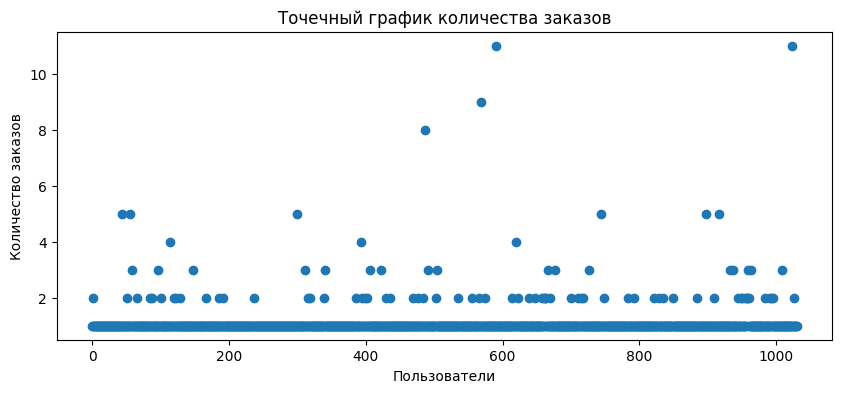

In [76]:
plt.figure(figsize=(10,4))
x_values = pd.Series(range(0,len(users_orders)))
plt.scatter(x_values, users_orders['orders']) 
plt.title('Точечный график количества заказов')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()


Большинство пользователей совершают 1-3 заказа, для определения порога аномалий рассчитаем 95-й и 99-й процентили.


### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Определим границу для определения аномальных пользователей.

In [77]:
print('95 перцентиль: %.2f' % (np.percentile(users_orders['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(users_orders['orders'], [99])))

95 перцентиль: 2.00
99 перцентиль: 4.00


Только 5% пользователей совершают более 2 заказов, и только 1% пользователей - больше 4.
Границу для определения аномальных пользователей определим по 95 прецентилю, т.е. пользователи, совершившие более 2 покупок.


### Построим точечный график стоимостей заказов. 

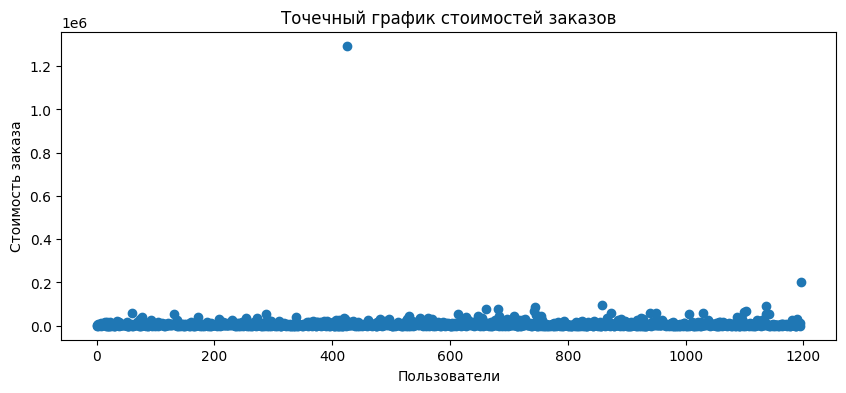

In [78]:
plt.figure(figsize=(10,4))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.show()

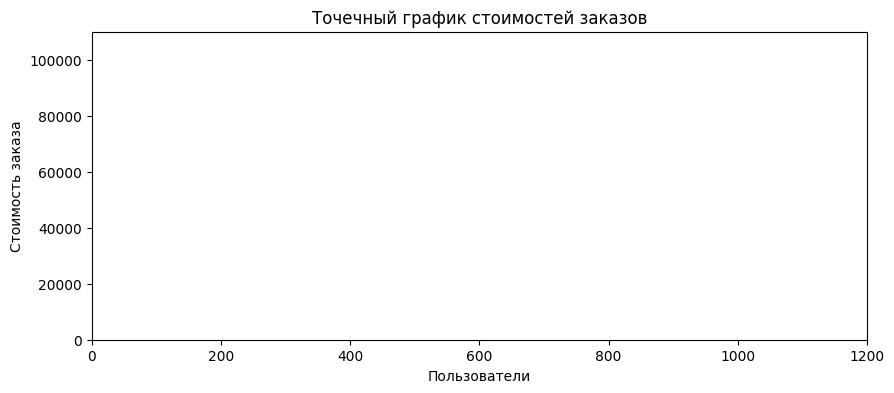

In [79]:
# построим тот же график в меньшем масштабе
plt.figure(figsize=(10,4))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.axis([0, 1200, 0, 110000])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.show()


На первом графике определяем 2 выбивающихся значения, которые, как раз таки могли повлиять на показатели, рассматриваемые ранее. Судя по второму графику, большая часть заказов интернет-магазина стоимостью до 30000.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [37]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 28000.00
99 перцентиль: 58233.20


В данных только 5% заказов сотоимостью более 28тыс заказов, и только 1% пользователей - более 58,233тыс. Границу для определения аномальных заказов определим по 95 прецентилю, т.е. заказы, стоимостью более 28тыс.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [38]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.029729
1,B,640,18916,0.033834


Для определения статистической значимости различий будем использовать Z-критерий для разности двух долей. 

Сформулируем гипотезы:
- **`H0:`** Конверсия в `группе A` по "сырым" данным **равна** конверсии в `группе B`
- **`H1:`** Конверсия в `группе A` по "сырым" данным **не равна** конверсии в `группе B`

In [39]:
alpha=0.05
purchases = np.array(conversion['orders'])
leads = np.array(conversion['visitors'])

p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / mth.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = sts.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, следовательно конверия в `группе А` **по "сырым" данным НЕ равна** конверсии в `группе В`. Конверсия группы В превышает значение конверсии группы А, различия статистически значимы.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Как было определено ранее, в данных о среднем чеке встречались значительные выбросы, которые могут сдвигать параметрические результаты, поэтому для оценки воспользуемся критерием Манна-Уитни.

Сформулируем гипотезы:
- `H0`: Средние чеки групп А и В по "сырым" данным **равны**  
- `H1`: **Существует разница** между средними чеками групп А и В по "сырым" данным 

In [40]:
alpha = 0.05
results = sts.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                           orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.7292909855432458
Не получилось отвергнуть нулевую гипотезу


Разница между средними чеками заказов по "сырым" данным групп А и В статистически не значима. 
### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

В предыдущих шагах нами были определены границы для определения аномальных пользователей.

In [41]:
# оставим пользователей, совершивших не более 2 заказов

orders_lmt = orders.query('revenue >= 2')
conversion_clear = (orders_lmt.groupby('group').agg({'transaction_id':'count'})\
                    .rename(columns={'transaction_id':'orders'})).join((visitors\
                    .groupby('group').agg({'visitors':'sum'}))).reset_index()


Для определения статистической значимости различий будем использовать Z-критерий для разности двух долей.

Сформулируем гипотезы:

- `H0`: Конверсия в `группе A` по "очищенным" данным **равна** конверсии в `группе B`
- `H1`: Конверсия в `группе A` по "очищенным" данным **не равна** конверсии в `группе B`

In [42]:
alpha=0.05
purchases = np.array(conversion_clear['orders'])
leads = np.array(conversion_clear['visitors'])
p1 = purchases[0] / leads[0]
p2 = purchases[1] / leads[1]
combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
difference = p1-p2
z_value = difference / mth.sqrt(combined * (1 - combined) * (1 / leads[0] + 1 / leads[1]))
distr = sts.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу


Конверсия в группе A по "очищенным" данным не равна конверсии в группе B, разнца статистически значима. Аналогично анализу "неочищенных данных".

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.


Сформулируем гипотезы:

- `H0`: Средние чеки групп А и В по "очищенным" данным **равны**
- `H1`: **Существует разница** между средними чеками групп А и В по "очищенным" данным

In [43]:
# оставим пользователей, совершивших не более 2 заказов
orders_clear = orders.query('revenue <= 28000')
alpha = 0.05
results = sts.mannwhitneyu(orders_clear[orders_clear['group']=='A']['revenue'],\
                           orders_clear[orders_clear['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.851874185940575
Не получилось отвергнуть нулевую гипотезу


Разница между средними чеками групп А и В по "очищенным" данным статистичекси не значима. Выбросы повлияли на результат теста.

## Вывод:

Нами были определены наиболее перспективные гипотезы на основе ICE и RICE:


- (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- (2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

По результатам А/В теста:

 Кумулятивные метрики по выручке, среднему чеку и конверсии на протяжении почти всего анализируемого периода лидировали в группе B. При этом, наблюдали увеличение выручки группы В с 20 августа почти в 2 раза, что было связано с увеличением среднего чека заказов в указанный промежуток времени за счет присутствия более крупных заказов. Отметим, что кумулятивный средний чек группы А стабильно уступает показателю группы В. Так же,  группа В лидирует по конверсии и имеет прирост около 15% относительно группы А.

Большинство пользователей совершают 1-3 заказа,в даных только 5% заказов сотоимостью более 28тыс, и только 1% пользователей - более 58,233тыс. Только 5% пользователей совершают более 2 заказов, и только 1% пользователей - больше 4. Границу для определения аномальных пользователей определим по 95 прецентилю, т.е. пользователи, совершившие более 2 покупок. Исходя из чего, нами были определены границы для определения аномальных пользователей: количество заказов больше 2 и сумма покупки более 58233.

Определена статистически значимая разница конверсий групп А и В, как по сырым данным, так и по данным после фильтрации аномалий, выше конверсия группы В. 
По средним чекам статистической разницы не зафиксировано ни в "сырых", ни в "очищенных" данных. 

На мой взгляд, мы можем **остановить тест и зафиксировать победу группы B**, так как, несмотря на отсутсвие различий в средних чеках двух групп, разница показателей конверсии между группами и до и после фильтрации данных является статистически значимой.